In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


# Studies in Digital Signal Processing, Project 4

### Initial auxiliary functions

In [2]:
def plot_freq_response(x_mag: np.ndarray, x_phase: np.ndarray, name: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), layout='constrained')
    plt.setp(ax[:], xlabel='Angular frequency ($\omega$)')
    plt.setp(ax[0], ylabel='Magnitude')
    plt.setp(ax[1], ylabel='Phase (Degrees)')
    ax[0].plot(x_mag)
    plt.setp(ax[0], title=f'Magnitude Spectrum ({name}[$\omega$])')
    ax[1].plot(x_phase)
    plt.setp(ax[1], title=f'Phase Spectrum ({name}[$\omega$])')
    plt.show()



## Section 1

Consider a signal $x\left[n\right]$ with 16 samples:

$$
x\left[n\right] = \left\{ 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 1\right\}
$$


### Section 1-A

In this section, we will calculate the DFT of the signal using the equation:

$$
X\left[k\right] = \sum_{n = 0}^{N-1} x\left[n\right] W_{N}^{kn}
$$

with $W_{N} = e^{-\frac{2 \pi}{N}}$.

In [3]:
signal = np.array([1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 1])

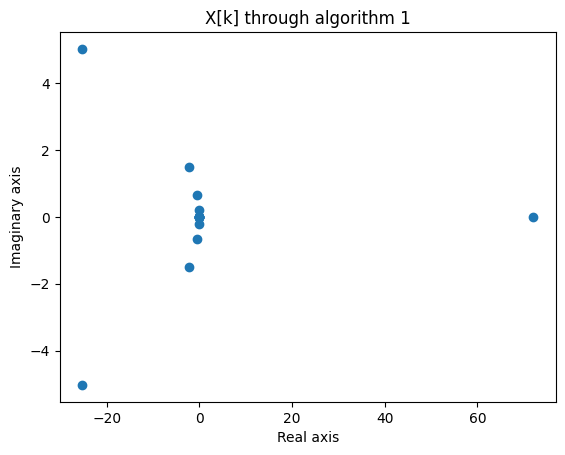

In [4]:
def dft(x: np.ndarray) -> np.ndarray:
    length = len(x)
    w_n = 2*np.pi/length
    response = np.zeros(length, dtype=complex)
    for i in range(length):
        for j in range(length):
            response[i] += x[j] * np.exp(-1j * i * j * w_n)
    return response


x_k = dft(signal)
plt.scatter(x_k.real, x_k.imag)
plt.title('X[k] through algorithm 1')
plt.ylabel('Imaginary axis')
plt.xlabel('Real axis')
plt.show()


### Section 1-B

Consider the separation of the signal $x\left[n\right]$ into its even and odd samples, $x_e\left[n\right]$ and $x_o\left[n\right]$, respectively.

In this section, we will compute the DFT of the signal $x\left[n\right]$ using the equation:

$$
\hat{X}\left[k\right] = X_e\left[k\right] + W_{N}^{k} X_o\left[k\right]
$$

Additionally, we will compare the two DFTs and calculate the mean absolute error (MAE) between the DFTs computed by the two techniques:

$$
MAE = \sum_{i = 0}^{N-1} \left| X\left[i\right] - \hat{X}\left[i\right]\right|
$$

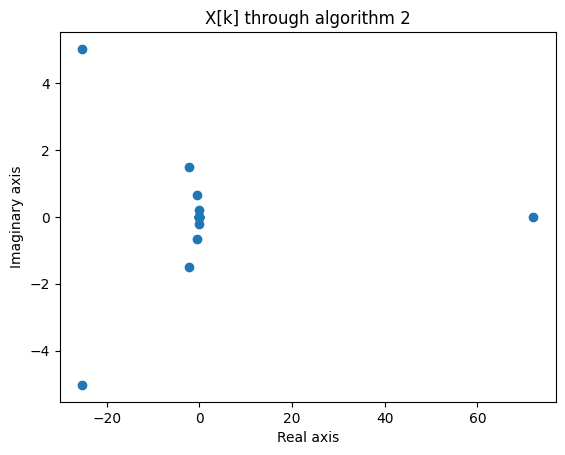

In [5]:
def dft2(x: np.ndarray) -> np.ndarray:
    N = len(x)
    if N <= 1:
        return x
    even = dft2(x[0::2])
    odd  = dft2(x[1::2])
    factor = np.exp(-2j * np.pi * np.arange(N) / N)
    first_half  = even + factor[:N//2] * odd
    second_half = even + factor[N//2:] * odd
    return np.concatenate([first_half, second_half])


x_k_2 = dft2(signal)
plt.scatter(x_k.real, x_k.imag)
plt.title('X[k] through algorithm 2')
plt.ylabel('Imaginary axis')
plt.xlabel('Real axis')
plt.show()


In [6]:
def calculate_mae(x1: np.ndarray, x2: np.ndarray) -> float:
    mae = 0
    for i in range(len(x1)):
        mae += abs(x1[i]-x2[i])
    return mae


mae = calculate_mae(x_k, x_k_2)
print('MAE =', mae)

MAE = 3.961525378760667e-13


## Section 2

The file "potencia.txt" contains data on the real envelope of a sinusoidal tone sampled at a rate of $200$ samples/second. To separate the large-scale fading, it is necessary to filter this signal with a low-pass filter with a cutoff frequency around $5$ Hz.


### Section 2-A

In this section, we will design a digital filter with the desired specification.

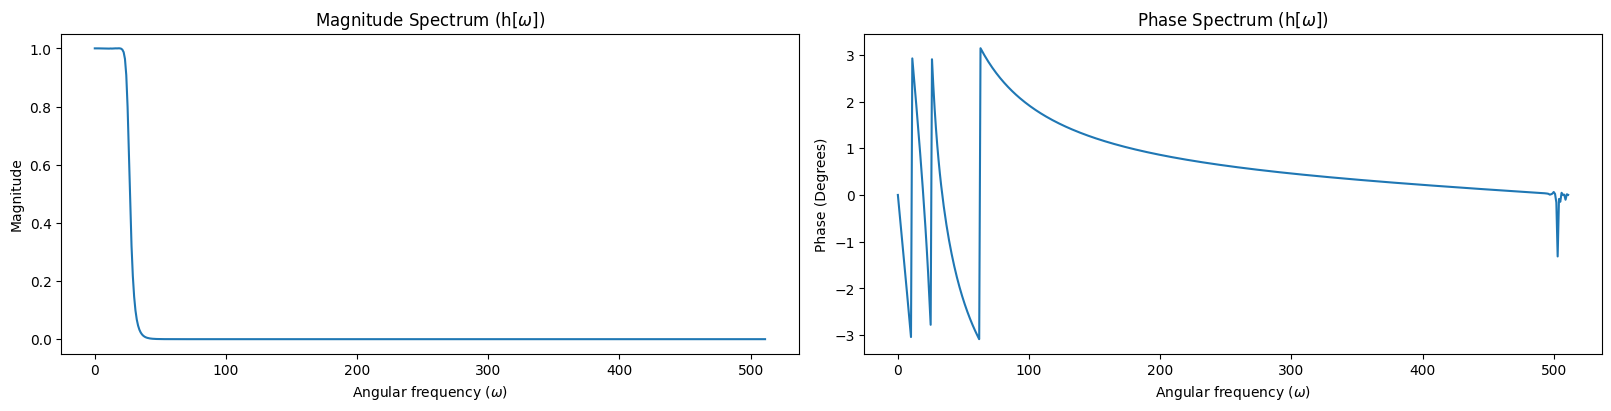

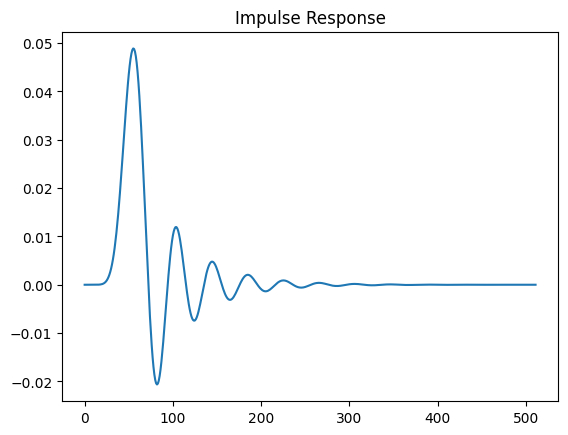

In [7]:
b, a = sp.signal.butter(N=12, Wn=5, fs=200, btype='lowpass')
w, response = sp.signal.freqz(b, a)
h_mag = abs(response)
h_freq = np.angle(response)
plot_freq_response(h_mag, h_freq, 'h')
impulse = np.zeros(512)
impulse[0] = 1
impulse_response = sp.signal.lfilter(b, a, impulse)
plt.plot(impulse_response)
plt.title('Impulse Response')
plt.show()


A low-pass filter was designed, the *butter* function from *SciPy* was used for this. The variables used were:
- $N=12$: filter order
- $Wn=5$: cutoff frequency
- $fs=200$: sampling rate
- *btype='lowpass'*: filter type

### Section 2-B

In this section, we will write a function to process a window of $N$ samples of the desired signal. $N$ should be chosen around 1 second of signal, approximately. Filtering should be done in the DFT domain.

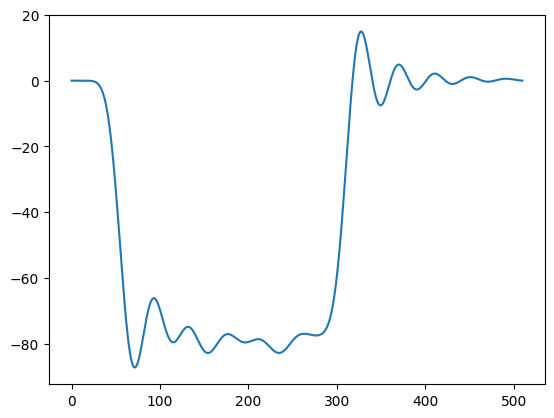

In [8]:
def process_window(signal, kernel):
    fft_length = len(signal) + len(kernel) - 1
    signal_fft = np.fft.fft(signal, fft_length)
    kernel_fft = np.fft.fft(kernel, fft_length)
    convolution = np.fft.ifft(signal_fft * kernel_fft)
    return np.real(convolution)


N = 256
x = np.zeros(N)
x[0] = 1
h_n = sp.signal.lfilter(b, a, x)
signal = np.loadtxt("potencia.txt")
window = signal[:N]
processed_window = process_window(window, h_n)
plt.plot(processed_window)
plt.show()


### Section 2-C

In this section, we will write a function to combine the output of each window's processing into the system output, using the method *Overlap-Add*.


In [9]:

def overlap_add(signal: np.ndarray, h_n: np.ndarray, N: int) -> np.ndarray:
    response = np.zeros(len(signal) + len(h_n) - 1)
    slices = [signal[i : i+N] for i in range(0, len(signal), N)]
    for i in range(len(slices)):
        y = process_window(slices[i], h_n)
        response[i*N : i*N + len(y)] += y
    return response


overlap_add_response = overlap_add(signal, h_n, N)


### Section 2-D

Let's plot the input and output signal of the system given by both windowed processing and full signal processing.

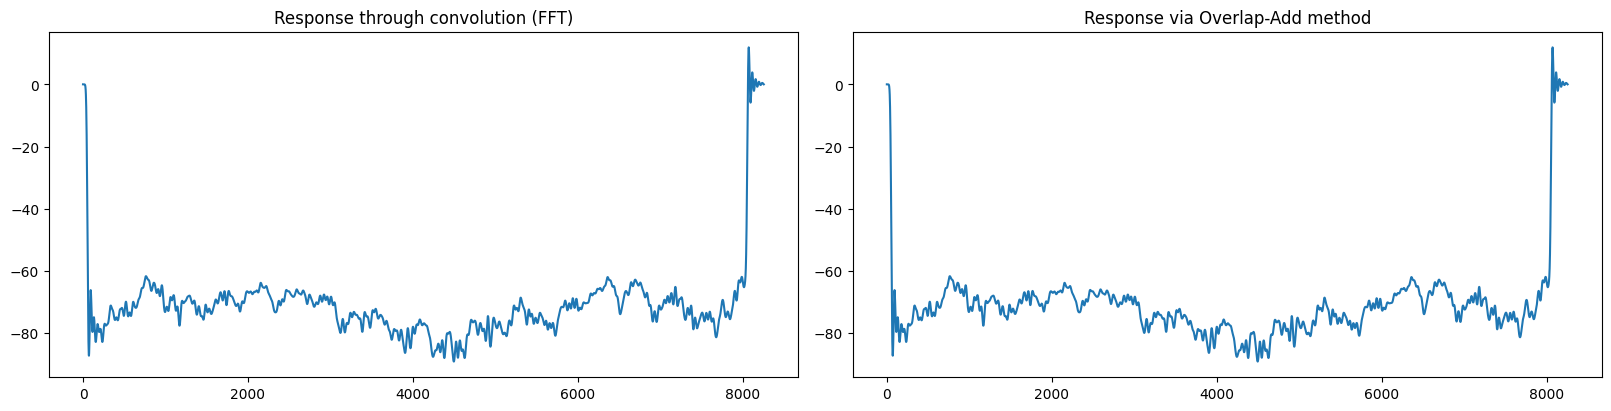

In [10]:
full_convolution_response = sp.signal.fftconvolve(signal, h_n)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), layout='constrained')
ax[0].plot(full_convolution_response)
plt.setp(ax[0], title='Response through convolution (FFT)')
ax[1].plot(overlap_add_response)
plt.setp(ax[1], title='Response via Overlap-Add method')
plt.show()


Using the *Overlap-Add* method, we observed that window processing resulted in a graph identical to that of full signal processing, as expected.

## Section 3

The difference equation for a FIR filter of size $N$ can be written as:

$$
\begin{align}
	y\left[n\right] &= h_0 x\left[n\right] + h_1 x\left[n-1\right] + h_2 x\left[n-2\right] + h_3 \left[n-3\right] + \ldots + h_{N-1} x\left[n - \left(N- 1\right)\right] \\
	       &= \sum_{k=0}^{N-1} h_k x\left[n - k\right] 
\end{align}
$$

The filter coefficients, or \textit{taps}, are expressed using the variable $h_k$ to emphasize that the coefficients themselves represent the impulse response of the filter. The frequency response of the filter is:

$$
\begin{align}
	H\left( \Omega \right) = \frac{Y\left( \Omega \right)}{X\left( \Omega \right)} = \sum_{k=0}^{N-1} h_k e^{-j \Omega k}
\end{align}
$$

Since $H\left( \Omega \right)$ is a function with period $2 \pi$ of the continuous variable $\Omega$, it is sufficient to specify $H\left( \Omega \right)$ in only one period $0 \leq \Omega < 2 \pi$.

In many applications, the desired magnitude response of the filter $\left|H_d \left( \Omega \right)\right|$ is known, but the filter coefficients $h_k$ are not. The question then becomes how to determine the filter coefficients from the desired magnitude response. We can do this by simply sampling the desired frequency response $\left|H_d \left( \Omega \right)\right|$ with $N$ samples in a period, and then performing the inverse DFT of these samples (obtaining $h\left[n\right]$). Note that defining the coefficients $h_k$ is sufficient to determine the FIR filter system. Furthermore, since $H \left( \Omega \right)$ was obtained by sampling $\left|H_d \left( \Omega \right)\right|$ for some frequencies, we are guaranteed that the frequency response of the designed filter will be equal to the desired frequency response at least at the sampled values. Finally, note that when doing the inverse DFT, some coefficients $h_k$ may have a small imaginary component that must be discarded for the design of a real filter.



### Section 3-A

Consider an ECG signal sampled at a rate of $500$ Hz. In this section, we will design a digital FIR filter by sampling the low-pass frequency with a cutoff frequency of $50$ Hz, plot the impulse response $h\left[n\right]$ and the frequency response $H\left(\Omega\right)$ of the filter for $N = 21$, $N = 31$, and $N = 41$, and compare the filters with the desired frequency response.

For a cutoff frequency $f_o = 50 \ Hz$ under a sampling rate of $500 \ Hz$, we have $2 \pi (\frac{50}{500}) = \frac{\pi}{5}$ and its conjugate $2\pi - \frac{\pi}{5}$.

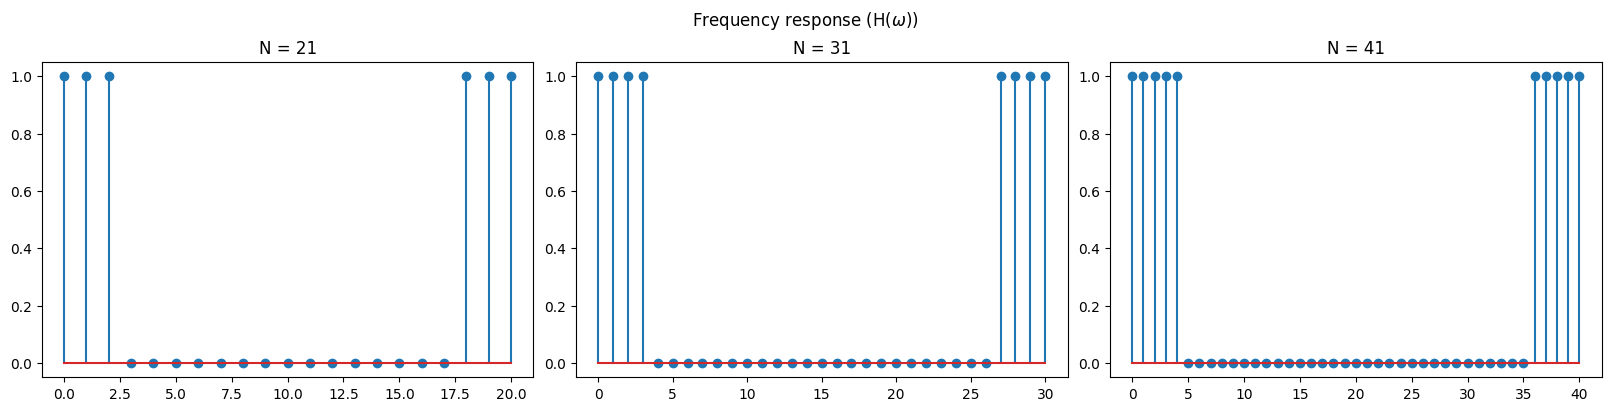

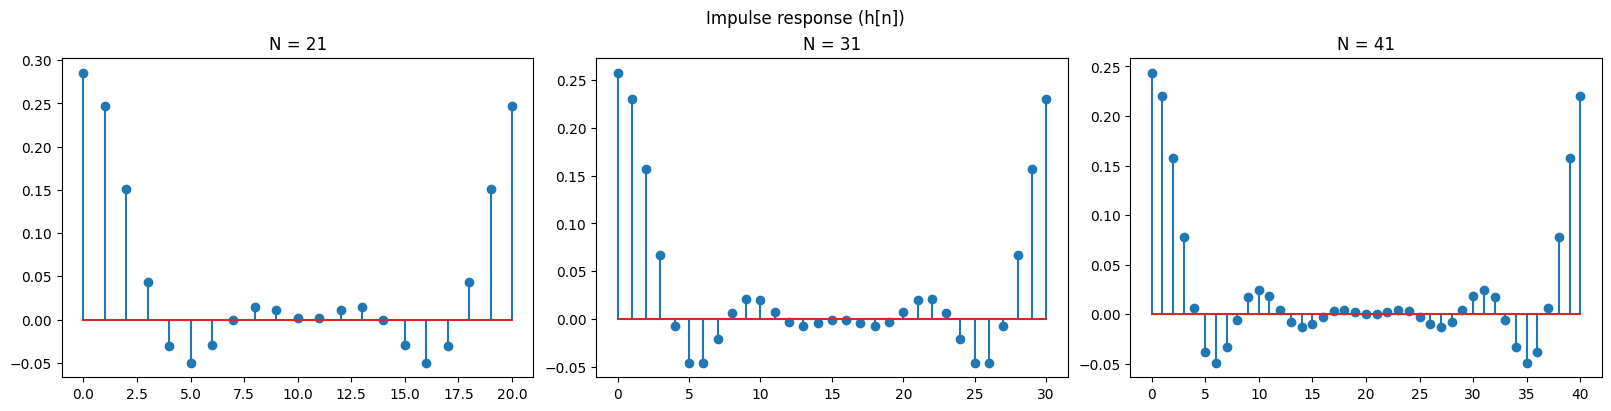

In [11]:
def h(x: np.ndarray) -> np.ndarray:
    length = len(x)
    response = np.zeros(length)
    for i in range(length):
        if x[i] <= np.pi/5 or x[i] >= 2*np.pi-np.pi/5:
            response[i] = 1
    return response


N = [21, 31, 41]
# Frequency response
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), layout='constrained')
fig.suptitle('Frequency response (H($\omega$))')
for i in range(len(N)):
    w = np.linspace(0, 2*np.pi, N[i])
    h_w = h(w)
    ax[i].stem(np.real(h_w))
    plt.setp(ax[i], title=f'N = {N[i]}')
plt.show()
# Impulse response
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), layout='constrained')
fig.suptitle('Impulse response (h[n])')
for i in range(len(N)):
    w = np.linspace(0, 2*np.pi, N[i])
    h_w = h(w)
    h_n = sp.fftpack.ifft(h_w)
    ax[i].stem(np.real(h_n))
    plt.setp(ax[i], title=f'N = {N[i]}')
plt.show()


The inverse Fourier transform of the function $rect$ is the function $sinc$, but the presence of aliasing in the impulse response $h[n]$ is clear.

### Section 3-B

The impulse response of the filter from the previous section should be a *sinc* function, which is a function with infinite support. However, the sampling only samples the part for positive $n$, generating a discontinuity and a poorer frequency response. One way to improve this sampling is to center the *sinc* function - to do this, we must multiply the frequency response of the filter $H\left(\Omega\right)$ by $e^{-j \Omega \frac{\left(N - 1\right)}{2}}$. We will use this technique to generate new filters with $N = 21$, $N = 31$ and $N = 41$, and eventually compare the filters with the filters from the previous section with the same size.

We will sample up to before 1 period, that is, $2\pi \Big(\frac{N-1}{N}\Big)$, so that there is no interference.

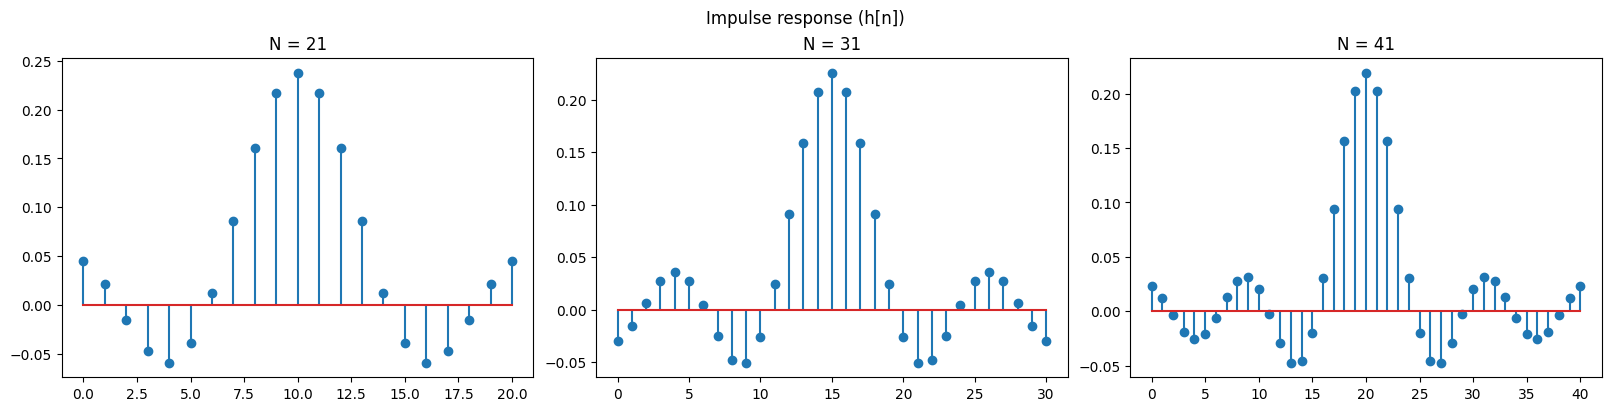

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), layout='constrained')
fig.suptitle('Impulse response (h[n])')
for i in range(len(N)):
    stop = 2*np.pi * ((N[i]-1)/N[i])
    w = np.linspace(start=0, stop=stop, num=N[i])
    h_w = h(w) * np.exp(-1j*(N[i]-1)/2*w)
    h_n = sp.fftpack.ifft(h_w)
    ax[i].stem(np.real(h_n))
    plt.setp(ax[i], title=f'N = {N[i]}')
plt.show()

By comparing each graph in this question with its respective graph in the previous question, the similarity of the new graph with the graph of a function $sinc$ becomes clear, something that was not clearly the case in the $h[n]$ of the previous section. Since the function $sinc$ is a function with infinite support, the operation performed alleviated this problem and brought a better frequency response.

### Section 3-C

Let's apply the filter with $N = 41$ to the signal from the file "noisy\_ecg\_data\_3.mat". We will compare the input signal with the output signal and try to answer the question: what happens to the ECG spikes?

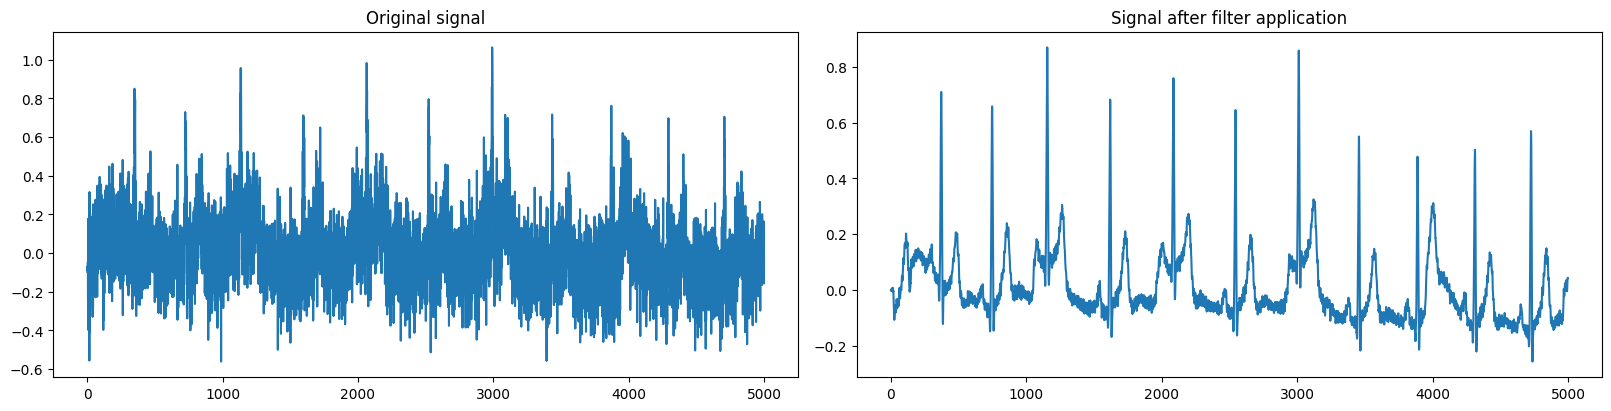

In [13]:
signal = sp.io.loadmat('noisy_ecg_data_3.mat')['noisy_ecg_3'].ravel()

stop = 2*np.pi * ((41-1)/41)
w = np.linspace(start=0, stop=stop, num=41)
h_w = h(w) * np.exp(-1j*(41-1)/2*w)
h_n = sp.fftpack.ifft(h_w)

A = np.zeros(len(h_n))
A[0] = 1
response = sp.signal.lfilter(h_n, A, signal)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), layout='constrained')
ax[0].plot(signal)
plt.setp(ax[0], title='Original signal')
ax[1].plot(np.real(response))
plt.setp(ax[1], title='Signal after filter application')
plt.show()


Comparing the original signal with the one after the filter was applied, we can notice that some interference that was previously present in the signal was filtered out, similar to what happened with Section 1-D of Project 2 of this project.

### Section 3-D

In this section, we will use the *zero-phase filtering* technique with the filter from the previous item, then compare the system output with and without the application of the technique.

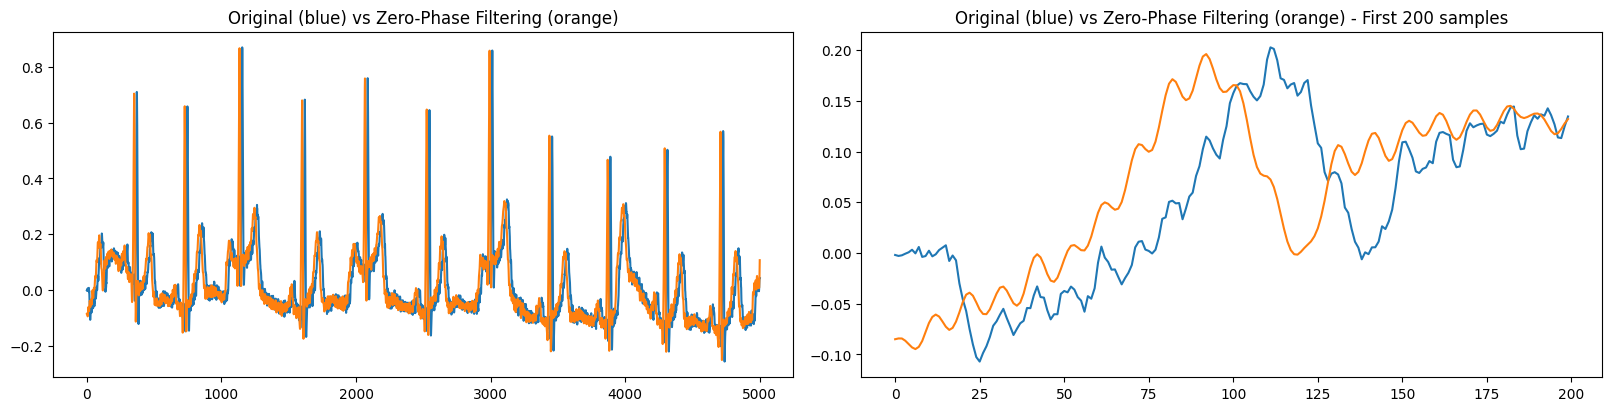

In [14]:
response_zpf = sp.signal.filtfilt(h_n, A, signal)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), layout='constrained')
ax[0].plot(np.real(response))
ax[0].plot(np.real(response_zpf))
plt.setp(ax[0], title='Original (blue) vs Zero-Phase Filtering (orange)')
ax[1].plot(np.real(response)[:200])
ax[1].plot(np.real(response_zpf)[:200])
plt.setp(ax[1], title='Original (blue) vs Zero-Phase Filtering (orange) - First 200 samples')
plt.show()

Using the graph that analyzes only the first 200 samples to facilitate visual understanding, we can mainly notice the phase difference between the two graphs. The Zero-Phase Filtering technique also changes the order and magnitude of the filter.